For looking at the results of one call to syn_ahrens_gnldr_mdls

In [1]:
%load_ext autoreload
%autoreload 2 

In [2]:
%matplotlib notebook

In [3]:
import copy
import glob
import pathlib
import pickle

import matplotlib.pyplot as plt
import numpy as np
import torch


from ahrens_wbo.annotations import label_subperiods
from ahrens_wbo.annotations import stim_dict
from ahrens_wbo.data_processing import generate_torch_dataset
from ahrens_wbo.data_processing import load_and_preprocess_data
from ahrens_wbo.data_processing import SegmentTable
from janelia_core.ml.datasets import TimeSeriesDataset
from janelia_core.ml.utils import list_torch_devices
from janelia_core.visualization.image_generation import max_project_pts
from janelia_core.visualization.matrix_visualization import cmp_n_mats
from probabilistic_model_synthesis.fa import orthonormalize
from probabilistic_model_synthesis.gaussian_nonlinear_dim_reduction import approximate_elbo
from probabilistic_model_synthesis.gaussian_nonlinear_dim_reduction import evaluate_check_points
from probabilistic_model_synthesis.gaussian_nonlinear_dim_reduction import infer_latents
from probabilistic_model_synthesis.gaussian_nonlinear_dim_reduction import Fitter
from probabilistic_model_synthesis.gaussian_nonlinear_dim_reduction import PriorCollection
from probabilistic_model_synthesis.gaussian_nonlinear_dim_reduction import VICollection
from probabilistic_model_synthesis.gnlr_ahrens_tools import find_period_time_points

## Parameters go here

In [4]:
ps = dir()

# Directory holding results
rs_dir = r'/groups/bishop/bishoplab/projects/probabilistic_model_synthesis/results/real_data/gnldr/same_cond_transfer_analysis/v1/fold_str_base_14_tgt_1/fold_0/subj_8/comb'
rs_file = r'test_results.pt'

# Specify which fit type we look at 
mdl_type = 'ip'

# True if we should use early stoppint to pick the best model
use_early_stopping = True

# Specify the seperate periods we want to measure performance on in the test data
test_periods = ['omr_forward', 'omr_left', 'omr_right']

## See what devices we have available

We will use the first if we have more than one

In [5]:
devices, _ = list_torch_devices()
device = devices[0]

Found 1 GPUs


## Load results

In [6]:
rs = torch.load(pathlib.Path(rs_dir) / rs_file)

In [7]:
fit_ps = rs['ps']
fit_rs = rs['rs']
subject_order = rs['subject_order']
fold = fit_ps['fold']
n_latent_vars = fit_ps['mdl_opts']['n_latent_vars']

## Look at fitting logs 

<IPython.core.display.Javascript object>


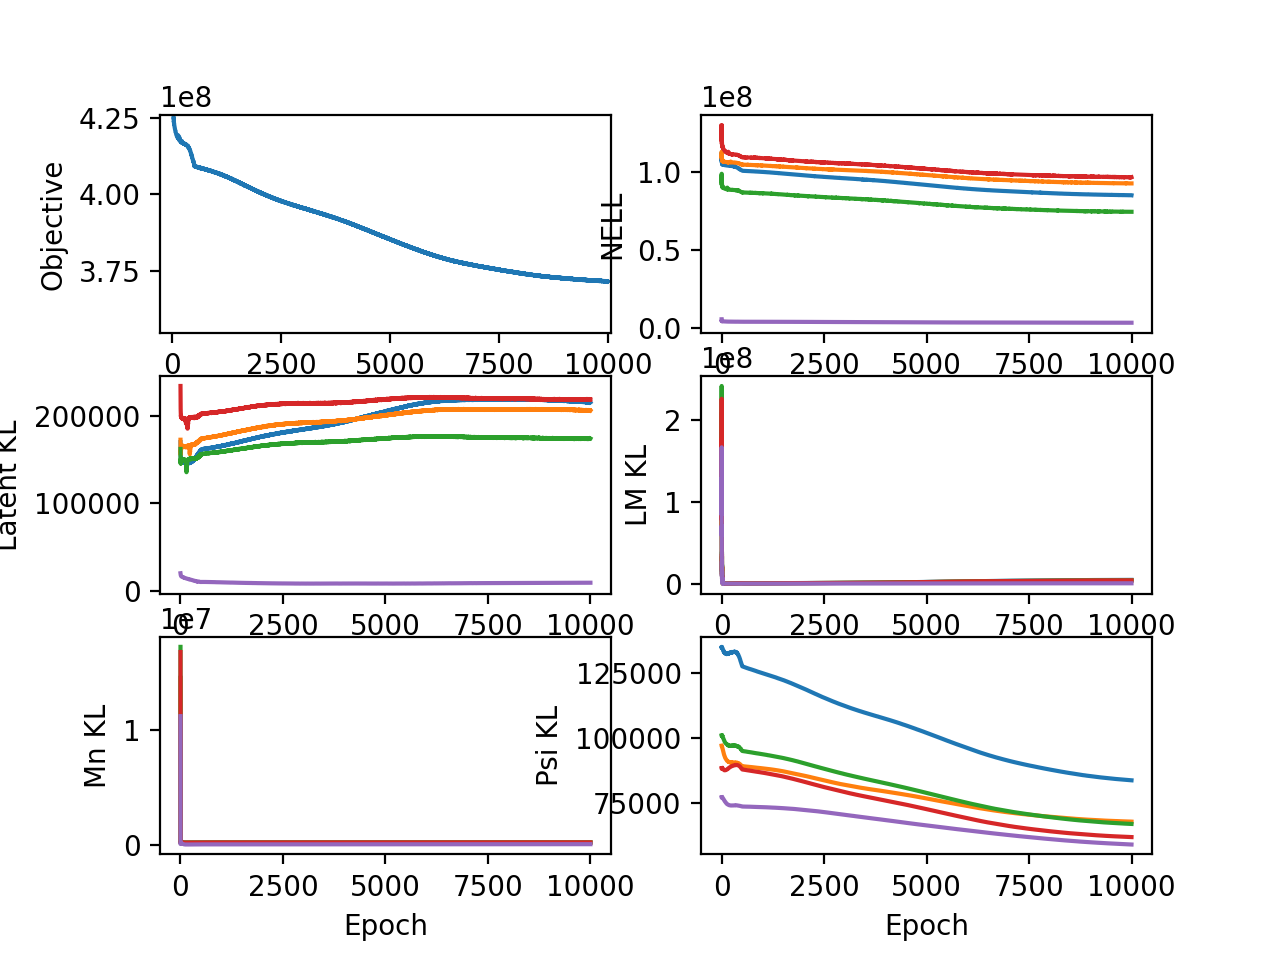

In [8]:
for log in fit_rs[mdl_type]['logs']:
    Fitter.plot_log(log)

## Load the segment tables, fold structures and data 

Load segment tables

In [9]:
segment_table_path = pathlib.Path(fit_ps['segment_table_dir']) / fit_ps['segment_table_file']
with open(segment_table_path, 'rb') as f:
    st_data = pickle.load(f)
    segment_tables = st_data['segment_tables']
segment_tables = {k: SegmentTable.from_dict(v) for k, v in segment_tables.items()}

Load fold structures

In [10]:
fold_str_path = pathlib.Path(fit_ps['fold_str_dir']) / fit_ps['fold_str_file']
with open(fold_str_path, 'rb') as f:
    fold_groups = pickle.load(f)


Load data

In [ ]:
subject_data, subject_neuron_locs = load_and_preprocess_data(data_folder=fit_ps['data_dir'], 
                                            subjects=subject_order,
                                            neural_gain=fit_ps['neural_gain'], 
                                            z_ratio=fit_ps['z_ratio'])

Done loading data for subject subject_1.


Form the train, validation and test data 

In [ ]:
data = dict()
for s_n in subject_order:
    subject_train_slices = segment_tables[s_n].find_all(fold_groups[s_n][fold]['train'])
    train_data_n = generate_torch_dataset(dataset=subject_data[s_n], 
                                          slices=subject_train_slices,
                                          ts_keys=['dff'], inc_time_stamps=True)
    
    train_data_n = (train_data_n.data[0], train_data_n.data[1])

    
    if fold_groups[s_n][fold]['test'] is not None:
        subject_test_slices = segment_tables[s_n].find_all(fold_groups[s_n][fold]['test'])
        test_data_n = generate_torch_dataset(dataset=subject_data[s_n], 
                                             slices=subject_test_slices,
                                             ts_keys=['dff'], inc_time_stamps=True)
    
        test_data_n = (test_data_n.data[0], test_data_n.data[1])
    else:
        test_data_n = None
    
    if fold_groups[s_n][fold]['validation'] is not None:
        subject_validation_slices = segment_tables[s_n].find_all(fold_groups[s_n][fold]['validation'])
        validation_data_n = generate_torch_dataset(dataset=subject_data[s_n], 
                                                   slices=subject_validation_slices,
                                                   ts_keys=['dff'], 
                                                   inc_time_stamps=True)
    
        validation_data_n = (validation_data_n.data[0], validation_data_n.data[1])
    else:
        validation_data_n = None
    
    data[s_n] = {'train': train_data_n, 
                 'test': test_data_n, 
                 'validation': validation_data_n}

## Get labels for all moments in time

In [ ]:
labels = {s_n: {'ts': subject_data[s_n].ts_data['stim']['ts'],
                'labels': label_subperiods(subject_data[s_n].ts_data['stim']['vls'][:])} for s_n in subject_order}

## Examine performance across checkpoints

In [ ]:
cv_strings = ['train', 'validation', 'test']

In [ ]:
n_subjects = len(subject_order)

cp_perf = dict()
cp_logs = dict()
for cv_string in cv_strings:
    cp_epochs, cp_perf[cv_string], cp_files, cp_logs[cv_string] = evaluate_check_points(
                                               cp_folder=pathlib.Path(fit_ps[mdl_type + '_cp_dir']), 
                                               data=[data[s_n][cv_string][0] for s_n in subject_order],
                                               props=[subject_neuron_locs[s_n] for s_n in subject_order],
                                               n_smps=1,
                                               fit_opts=None,
                                               elbo_opts=None,
                                               device=device)

## View a log for the latent estimation for on of the checkpoints

In [ ]:
cp_log = cp_logs['test'][10][0]

In [ ]:
Fitter.plot_log(cp_log)

## View performance across check points

In [ ]:
cp_type = 'validation'

In [ ]:
cp_avg = np.nanmean(cp_perf[cp_type], axis=1)

In [ ]:
plt.figure()
plt.plot(cp_epochs, cp_perf[cp_type])
plt.legend(subject_order)
plt.plot(cp_epochs, cp_avg, 'k--')
plt.xlabel('Epoch')
plt.ylabel('ELBO')

## Pick best check point based on early stopping

In [ ]:
if use_early_stopping:
    best_cp_ind = np.argmax(cp_avg)
    best_cp= torch.load(cp_files[best_cp_ind])
    eval_vi_colls = [VICollection.from_checkpoint(coll) for coll in best_cp['vi_collections']]
    eval_priors = PriorCollection.from_checkpoint(best_cp['priors'])
    print('Best CP Epoch: ' + str(cp_epochs[best_cp_ind]))
else:
    eval_vi_colls = fit_rs[mdl_type]['vi_collections']
    eval_priors = fit_rs[mdl_type]['priors']

Repopulate properties in the vi collection

In [ ]:
for s_i, s_n in enumerate(subject_order):
    eval_vi_colls[s_i].props = subject_neuron_locs[s_n]

## Infer latents for the picked model

In [ ]:
latents = dict()
for s_i, s_n in enumerate(subject_order):
    sub_latents = dict()
    for cv_string in cv_strings:
        if data[s_n][cv_string] is not None:
            latents_posts, latent_log = infer_latents(n_latent_vars=n_latent_vars,
                                                  vi_collection=eval_vi_colls[s_i],
                                                  data=data[s_n][cv_string][0],
                                                  fit_opts={'n_epochs': 100, 'init_lr':.1, 'update_int':None, 
                                                            'milestones': [50], 'n_batches': 2}, 
                                                  device=device, 
                                                  distribute_data=True)
        
        
            sub_latents[cv_string] = {'posts': latents_posts, 'log': latent_log}
            print('Done infering latents for subject ' + str(s_n) + ', ' + cv_string + '.')
        else:
            sub_latents[cv_string] = None
    latents[s_n] = sub_latents

## View a log for latent inference

In [ ]:
latent_view_log = latents[8]['validation']['log']

In [ ]:
Fitter.plot_log(latent_view_log)

## Evaluate ELBO on training, validation and testing data for evaluation models

In [ ]:
elbo_vls = dict()
for s_i, s_n in enumerate(subject_order):
    eval_coll_i = copy.deepcopy(eval_vi_colls[s_i])
    subj_elbo = dict()
    for cv_string in cv_strings:
        if latents[s_n][cv_string] is not None:
            eval_coll_i.data = data[s_n][cv_string][0]
            eval_coll_i.posteriors.latent_post = latents[s_n][cv_string]['posts']
            with torch.no_grad():
                subj_elbo[cv_string] = approximate_elbo(coll=eval_coll_i, priors=eval_priors, n_smps=10)
            print('Done estimagint ELBO for subject ' + str(s_n) + ', ' + cv_string + '.')
        else:
            subj_elbo[cv_string] = None
    elbo_vls[s_n] = subj_elbo

In [ ]:
for cv_string in cv_strings:
    print('***** ' + cv_string + ' *****')
    for s_n in subject_order:
        if elbo_vls[s_n][cv_string] is not None:
            print('Subject ' + str(s_n) + ':' + '{:.2E}'.format(elbo_vls[s_n][cv_string]['elbo'].item()))
        else:
            print('None')

## Evaluate ELBO on the different periods in the testing data 

In [ ]:
period_elbo_vls = dict()
for s_i, s_n in enumerate(subject_order):
    period_elbo_vls[s_n] = dict()
    if data[s_n]['test'] is not None:
        test_ts = data[s_n]['test'][1].numpy()
        for test_period in test_periods:
            test_inds = find_period_time_points(cand_ts=test_ts, 
                                                period=test_period,
                                                shock=False,
                                                labels=labels[s_n])
            if len(test_inds) > 0:
                eval_coll_i = copy.deepcopy(eval_vi_colls[s_i])
                eval_coll_i.data = data[s_n]['test'][0][test_inds,:]
                latent_post = copy.deepcopy(latents[s_n]['test']['posts'])
                latent_post.n = len(test_inds)
                latent_post.mns.data = latent_post.mns.data[test_inds,:]
                eval_coll_i.posteriors.latent_post = latent_post
                with torch.no_grad():
                    period_elbo_vls[s_n][test_period] = approximate_elbo(coll=eval_coll_i, priors=eval_priors, n_smps=10)
    else:
        period_elbo_vls[s_n] = None
                

In [ ]:
for s_n in subject_order:
    print('Period ELBO Values on Test Data for Subject ' + str(s_n))
    if period_elbo_vls[s_n] is not None:
        for test_period in period_elbo_vls[s_n].keys():
            print(test_period + ': ELBO ' + str(period_elbo_vls[s_n][test_period]['elbo'].item()) + 
                  ', ELL: ' + str(period_elbo_vls[s_n][test_period]['ell'].item()))
    else:
        print('None')

## Orthonormalize latents

In [ ]:
# TODO: Still need to account for scales here
lm_conc = np.concatenate([eval_vi_colls[s_i].posteriors.lm_post(subject_neuron_locs[s_n]).detach().numpy()
           for s_i, s_n in enumerate(subject_order)], axis=0)

In [ ]:
for s_n in subject_order:
    for cv_string in cv_strings:
        if latents[s_n][cv_string] is not None:
            mns = latents[s_n][cv_string]['posts'].mns.detach().numpy()
            _, mns_o = orthonormalize(lm=lm_conc, latents=mns)
            latents[s_n][cv_string]['mns'] = mns
            latents[s_n][cv_string]['mns_o'] = mns_o

## Visualize latents

In [ ]:
plot_cv_string = 'test'

In [ ]:
plt.figure()
for s_n in subject_order:
    if latents[s_n][plot_cv_string] is not None:
    
        subject_ts = subject_data[s_n].ts_data['stim']['ts']
        subject_stim = subject_data[s_n].ts_data['stim']['vls'][:]
    
        left_ts = subject_ts[subject_stim == stim_dict['phototaxis_left']]
        right_ts = subject_ts[subject_stim == stim_dict['phototaxis_right']]
    
        cv_ts = data[s_n][plot_cv_string][1]
        _, left_inds, _ = np.intersect1d(cv_ts, left_ts, return_indices=True)
        _, right_inds, _ = np.intersect1d(cv_ts, right_ts, return_indices=True)
    
    
        plt.plot(latents[s_n][plot_cv_string]['mns_o'][left_inds, 0],
                 latents[s_n][plot_cv_string]['mns_o'][left_inds, 1], 'r.')
    
        plt.plot(latents[s_n][plot_cv_string]['mns_o'][right_inds, 0],
                 latents[s_n][plot_cv_string]['mns_o'][right_inds, 1], 'b.')

## Visualize loading matrices across space

In [ ]:
lm_conc_o,_ = orthonormalize(lm=lm_conc)
lm_o = dict()
cur_start = 0
for s_n in subject_order:
    n_vars_n = data[s_n]['train'][0].shape[1]
    lm_o[s_n] = lm_conc_o[cur_start:cur_start+n_vars_n]
    cur_start += n_vars_n

In [ ]:
vis_comp = 49

In [ ]:
mode_imgs = dict()
for s_n in subject_order:
    neuron_locs_n = subject_neuron_locs[s_n]
    
    lm_n = lm_o[s_n]
    
    mode_imgs[s_n], _ = max_project_pts(dot_positions=neuron_locs_n.numpy()[:,[0,1]].astype('float'),
                                        dot_vls=lm_n[:,vis_comp], 
                                        box_position=np.asarray([[0, 0], [990, 610]]), 
                                        n_divisions=np.asarray([990, 610]), 
                                        dot_dim_width=np.asarray([5,5]))
    
 

In [ ]:
plt.figure()
cmp_n_mats([mode_imgs[k] for k in mode_imgs.keys()])  

## Debug code goes here

In [ ]:
eval_vi_colls = fit_rs[mdl_type]['vi_collections']
eval_priors = fit_rs[mdl_type]['priors']

In [ ]:
vis_imgs = dict()

for s_i, s_n in enumerate(subject_order):
    neuron_locs_n = subject_neuron_locs[s_n]
    
    std_vls = eval_vi_colls[s_i].posteriors.lm_post.dists[0].std_f(neuron_locs_n).detach().numpy()
    #std_vls = eval_priors.s_prior.std_f(neuron_locs_n).detach().numpy()
    
    #std_vls = eval_vi_colls[s_i].posteriors.psi_post.mode(neuron_locs_n).detach().numpy()
    #std_vls = eval_priors.psi_prior.mode(neuron_locs_n).detach().numpy()
    
    
    vis_imgs[s_n], _ = max_project_pts(dot_positions=neuron_locs_n.numpy()[:,[0,1]].astype('float'),
                                        dot_vls=std_vls, 
                                        box_position=np.asarray([[0, 0], [990, 610]]), 
                                        n_divisions=np.asarray([990, 610]), 
                                        dot_dim_width=np.asarray([5,5]))
    

In [ ]:
plt.figure()
cmp_n_mats([vis_imgs[k] for k in mode_imgs.keys()], show_colorbars=True, clim=[0, 1.0])  

In [ ]:
post_dist = eval_vi_colls[1].posteriors.latent_post

In [ ]:
#post_dist = latents[1]['validation']['posts']

In [ ]:
cov_m = post_dist.cov().detach().numpy()

In [ ]:
plt.figure()
plt.imshow(cov_m)
plt.colorbar()

In [ ]:
mns = post_dist.mns.detach().numpy()

In [ ]:
plt.figure()
for d_i in range(5):
    plt.plot(mns[:,d_i])